Jump to the last cell for final plot

# Lightcurve Generator

Generate BBH in AGN disk model lightcurves for a given event

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns  
from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import LogLocator, FuncFormatter
import pickle

import synphot
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
from astropy.modeling.physical_models import BlackBody  
from synphot.models import Empirical1D
from synphot import SourceSpectrum, SpectralElement, Observation
from synphot.models import BlackBodyNorm1D, Empirical1D
from synphot.units import PHOTLAM, FLAM
import matplotlib

import matplotlib.patches as patches
from scipy.interpolate import interp1d
from matplotlib import cm
import json
from datetime import datetime
import os

/Users/simran/anaconda3/lib/python3.11/site-packages/seaborn/_statistics.py:31: UserWarning: A NumPy version >=1.26.4 and <2.7.0 is required for this version of SciPy (detected version 1.26.3)
  from scipy.stats import gaussian_kde


# Events

In [2]:
# read the event info json file
with open('event_data.json', 'r') as f:
    event_info = json.load(f)

Extract event info

In [85]:
# Total number of events
num_events = len(event_info)
print(f"Total number of events: {num_events}")
# Extract names of events
event_names = list(event_info.keys())
event_names


Total number of events: 10


['S250830bp',
 'S250727dc',
 'S250725j',
 'S250328ae',
 'S250223dk',
 'S250205bk',
 'S240915b',
 'S240511i',
 'S240422ed',
 'S240413p']

In [206]:
# event to analyze
superevent = 'S240413p'  

In [ ]:
# Event chirp masses
event_chirp_masses = event_info[superevent]["chirp_mass"] 
print("Event Chirp Masses:", event_chirp_masses)
# Event total masses
event_total_mass = event_info[superevent]["total_mass"]
print("Event Total Masses:", event_total_mass)
# Event dLs
event_dLs = event_info[superevent]["dL"]
print("Event dLs (Mpc):", event_dLs)
# Event start mjds
event_start_iso = event_info[superevent]["start"]
event_start_mjds = Time(event_start_iso).mjd
print("Event Start MJDs:", event_start_mjds)

event_epochs_mjd = {}
event_epochs_iso = {}

epochs = event_info[superevent]["transient_magnitudes"].keys()

iso_dates = [
    datetime.strptime(ep, "%Y%m%d").strftime("%Y-%m-%d")
    for ep in epochs
]
mjds = Time(iso_dates, scale="utc").mjd

event_epochs_iso = iso_dates
event_epochs_mjd = mjds
target_times = event_epochs_mjd - event_start_mjds


print("Event Epochs (ISO):", event_epochs_iso)
print("Event Epochs (MJD):", event_epochs_mjd)
print("Target Times (days from merger):", target_times)

event_mags = {}
for epoch, mags in event_info[superevent]["transient_magnitudes"].items():
    # Convert epoch to MJD
    mjd = Time(
        datetime.strptime(epoch, "%Y%m%d"),
        scale="utc"
    ).mjd
    time_from_merger = mjd - event_start_mjds

    event_mags[time_from_merger] = mags

print("Event Magnitudes:", event_mags)

Event Chirp Masses: 12.113636363636363
Event Total Masses: 29.597226478854935
Event dLs (Mpc): 526
Event Start MJDs: 60413.0
Event Epochs (ISO): ['2024-04-15', '2024-04-16', '2024-05-05']
Event Epochs (MJD): [60415. 60416. 60435.]
Target Times (days from merger): [ 2.  3. 22.]
Event Magnitudes: {2.0: {'r': 22.323632363236324, 'i': 21.83058305830583}, 3.0: {'i': 21.6995699569957}, 22.0: {'i': 22.144614461446146}}


Model functions

In [208]:
def t_ram(M_BBH, kick_velocity):
    return 20 * (M_BBH / 100) * (kick_velocity / 200)**(-3) # there is another exp in terms of G, Mbbh and vk but this is correct too

def t_diff(M_SMBH, aspect_ratio, height, optical_depth):
    diffusion_time = (
        8
        * (optical_depth / 100)
        * ( height / (aspect_ratio * 0.01))
        * (aspect_ratio / 700)
        * (M_SMBH / 10**8)
    )
    return diffusion_time

def t_end(M_SMBH, kick_velocity, a, aspect_ratio, theta):
    time_end = (
        67 
        * (kick_velocity / 200)**(-1) 
        * (a / 700) 
        * (M_SMBH / 10**8) 
        * (aspect_ratio / 0.01)
        * (1 / np.sin(theta / 60))
    )
    return time_end

def L_BHL(M_BBH , kick_velocity, density, radiative_efficiency):
    lumi = (
        2.5 * 10**45
        * (radiative_efficiency / 0.1)
        * (M_BBH / 100)**2
        * ((kick_velocity+50) / 200)**(-3)
        * (density / 10**(-10))
    )
    return lumi

def t_exit(height, mp_optical_depth, kick_velocity):
    return (height * np.sqrt(2 * np.log(mp_optical_depth))) / kick_velocity


## Calculations

Parameters:
- Kick Velocity (vk)
- Disk Density (rho)
- Height of the disk (height) 
- Merger Point Optical Depth (mp_optical_depth)
- Angle at which BH is kicked wrt disk plane (theta)
- Mass of SMBH 
- Radiative Efficiency

Fiducial Model:
- vk: variable
- rho0: variable
- height: 700rg * 0.01 (fixed for all cases later)
- mp_optical_depth: C*rho0
- theta: 60 deg (fixed for all cases later)
- radiative_efficiency (fixed)
- mSMBH (fixed)


Note: Most important parameters here are kick velocity and density as they play a role in start and peak of the signature. Other params mostly affect the aftermath of the peak.

In [209]:
# Define the parameters for the grid
vk_array = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]) # km/s   
rho_array = np.logspace(-7, -12, num=6, base=10)

a = 700 # rg
aspect_ratio = 0.01
height_array = aspect_ratio * a 

C = 10**12
theta_array = np.array([60]) #[30, 45, 60, 75])

vk_grid, rho_grid = np.meshgrid(vk_array, rho_array, indexing='ij')

radiative_efficiency = 0.1
mSMBH = 10**8

vk_array, rho_array, vk_grid, rho_grid

(array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
 array([1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12]),
 array([[ 100,  100,  100,  100,  100,  100],
        [ 200,  200,  200,  200,  200,  200],
        [ 300,  300,  300,  300,  300,  300],
        [ 400,  400,  400,  400,  400,  400],
        [ 500,  500,  500,  500,  500,  500],
        [ 600,  600,  600,  600,  600,  600],
        [ 700,  700,  700,  700,  700,  700],
        [ 800,  800,  800,  800,  800,  800],
        [ 900,  900,  900,  900,  900,  900],
        [1000, 1000, 1000, 1000, 1000, 1000]]),
 array([[1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
        [1.e-07, 1.e-08, 1.e-09, 1.e-10, 1.e-11, 1.e-12],
    

In [210]:
# Start times

sig_start_times = t_ram(event_total_mass, vk_grid)
print("sig_start_times:", sig_start_times)

peak_times = 2 * sig_start_times
peak_luminosities = L_BHL(event_total_mass, vk_grid, rho_grid, radiative_efficiency)
# End times
#exit_times = t_exit(height_grid, mp_optical_depth_grid, vk_grid)

#peak_times = np.where(peak_times > end_times, end_times, peak_times)
end_times = t_end(mSMBH, vk_grid, a, aspect_ratio, theta_array[0])

sig_start_times: [[47.35556237 47.35556237 47.35556237 47.35556237 47.35556237 47.35556237]
 [ 5.9194453   5.9194453   5.9194453   5.9194453   5.9194453   5.9194453 ]
 [ 1.75390972  1.75390972  1.75390972  1.75390972  1.75390972  1.75390972]
 [ 0.73993066  0.73993066  0.73993066  0.73993066  0.73993066  0.73993066]
 [ 0.3788445   0.3788445   0.3788445   0.3788445   0.3788445   0.3788445 ]
 [ 0.21923871  0.21923871  0.21923871  0.21923871  0.21923871  0.21923871]
 [ 0.13806286  0.13806286  0.13806286  0.13806286  0.13806286  0.13806286]
 [ 0.09249133  0.09249133  0.09249133  0.09249133  0.09249133  0.09249133]
 [ 0.06495962  0.06495962  0.06495962  0.06495962  0.06495962  0.06495962]
 [ 0.04735556  0.04735556  0.04735556  0.04735556  0.04735556  0.04735556]]


Lightcurves

In [ ]:
# Define the light curve model
def gaussian_rise(rise_array, peak_lumi):
    t = rise_array
    t0 = t[-1]                 # peak at end
    tg = t0 - t[0]             # width
    start_val = np.exp(-((t[0] - t0)**2) / (2 * tg**2))
    return peak_lumi * (np.exp(-((t - t0)**2) / (2 * tg**2)) - start_val) / (1 - start_val)



def exponential_decay(fall_array, peak_lumi):
    t = fall_array
    t0 = t[0]
    t_end = t[-1]
    te = t_end - t0
    return peak_lumi * (np.exp(-(t - t0) / te) - np.exp(-(t_end - t0) / te)) / (1 - np.exp(-(t_end - t0) / te))


def light_curve_model(times, peak_lumi):
    rise_times = np.linspace(times[0], times[1], 100)
    fall_times = np.linspace(times[1], times[2], 100)

    rise_lumis = gaussian_rise(rise_times, peak_lumi)
    fall_lumis = exponential_decay(fall_times, peak_lumi)
    
    return rise_times, fall_times, rise_lumis, fall_lumis


QSO Bolometric Correction Factor based SED

In [ ]:
bandpasses = np.loadtxt('../data/decam_transmission_curves.txt', skiprows=1)
wav = bandpasses[:, 0] * u.AA  # Wavelengths in Angstroms
filter_g = bandpasses[:, 1]
filter_r = bandpasses[:, 2]
filter_i = bandpasses[:, 3]
filter_z = bandpasses[:, 4]

sort_idx = np.argsort(wav)
wav = wav[sort_idx]
filter_g = filter_g[sort_idx]
filter_r = filter_r[sort_idx]
filter_i = filter_i[sort_idx]
filter_z = filter_z[sort_idx]

In [213]:
# Compute effective wavelength for each filter (in Angstroms)
def effective_wavelength(wav, trans):
    return np.trapz(wav * trans, wav) / np.trapz(trans, wav)

lam_eff_g = effective_wavelength(wav.value, filter_g)
lam_eff_r = effective_wavelength(wav.value, filter_r)
lam_eff_i = effective_wavelength(wav.value, filter_i)
lam_eff_z = effective_wavelength(wav.value, filter_z)

print(f"Effective wavelengths (Å):")
print(f"  DECam g: {lam_eff_g:.2f}")
print(f"  DECam r: {lam_eff_r:.2f}")
print(f"  DECam i: {lam_eff_i:.2f}")
print(f"  DECam z: {lam_eff_z:.2f}")

Effective wavelengths (Å):
  DECam g: 4826.80
  DECam r: 6432.06
  DECam i: 7826.68
  DECam z: 9178.95


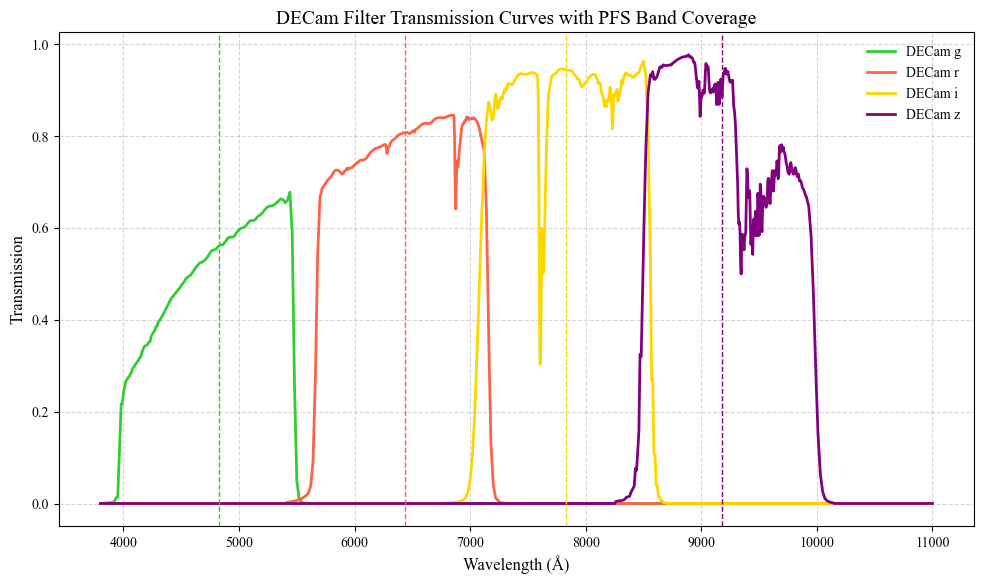

In [214]:
# Plot DECam transmission curves
plt.figure(figsize=(10, 6))
plt.plot(wav, filter_g, label='DECam g', color='limegreen', lw=2)
plt.plot(wav, filter_r, label='DECam r', color='tomato', lw=2)
plt.plot(wav, filter_i, label='DECam i', color='gold', lw=2)
plt.plot(wav, filter_z, label='DECam z', color='purple', lw=2)

# Plot CWL for Decam filters
plt.axvline(lam_eff_g, color='limegreen', ls='--', lw=1)
plt.axvline(lam_eff_r, color='tomato', ls='--', lw=1)
plt.axvline(lam_eff_i, color='gold', ls='--', lw=1)
plt.axvline(lam_eff_z, color='purple', ls='--', lw=1)

# Plot formatting
plt.xlabel('Wavelength (Å)', fontsize=12)
plt.ylabel('Transmission', fontsize=12)
plt.title('DECam Filter Transmission Curves with PFS Band Coverage', fontsize=14)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.grid(True, ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [215]:
peak_luminosities.shape

(10, 6)

In [ ]:
L_bol = np.array(peak_luminosities) * u.erg / u.s
print(f"L_bol shape: {L_bol.shape}")

dL = event_dLs * u.Mpc
dL = dL.to(u.cm)
print(f"Source distance dL = {dL.to(u.Mpc)}")
z = z_at_value(cosmo.luminosity_distance, dL)
print(f"Redshift z = {z}")

eff_wavelengths = {
    'DECam_g': lam_eff_g,
    'DECam_r': lam_eff_r,
    'DECam_i': lam_eff_i,
    'DECam_z': lam_eff_z,
}

# Runnoe et al. (2012) correction factors
runnoe_coeffs = {
    1450: {'C': 4.2},
    3000: {'C': 5.2},
    5100: {'C': 8.1},
}

def L_lambda_from_Lbol(Lbol, lam_eff):
    """Compute λLλ from Lbol using nearest Runnoe correction factor."""
    ref_wavelength = min(runnoe_coeffs.keys(), key=lambda w: abs(w - lam_eff))
    C = runnoe_coeffs[ref_wavelength]['C']
    return Lbol / C  # λLλ in erg/s

c = 2.99792458e18  
magnitudes = {band: np.zeros(L_bol.shape) for band in eff_wavelengths.keys()}

for i in range(L_bol.shape[0]):      
    for j in range(L_bol.shape[1]):  
        Lbol = L_bol[i, j]

        for band, lam in eff_wavelengths.items():
            L_lam = L_lambda_from_Lbol(Lbol, lam)
            L_nu = L_lam * (lam / c)
            F_nu = L_nu / (4 * np.pi * dL**2 * (1 + z))
            m_AB = -2.5 * np.log10(F_nu.value) - 48.6
            magnitudes[band][i, j] = m_AB


rows = []
for i in range(L_bol.shape[0]):
    for j in range(L_bol.shape[1]):
        row = {'vk_index': i, 'rho_index': j}
        for band in magnitudes.keys():
            row[band] = magnitudes[band][i, j]
        rows.append(row)

mag_df = pd.DataFrame(rows)
print("\nDataFrame shape:", mag_df.shape)
#mag_df

L_bol shape: (10, 6)
Source distance dL = 525.9999999999999 Mpc
Redshift z = 0.1098328819872281 redshift

DataFrame shape: (60, 6)


,vk_index,rho_index,DECam_g,DECam_r,DECam_i,DECam_z
0,0,0,10.278820,9.967093,9.754025,9.580986
1,0,1,12.778820,12.467093,12.254025,12.080986
2,0,2,15.278820,14.967093,14.754025,14.580986
3,0,3,17.778820,17.467093,17.254025,17.080986
4,0,4,20.278820,19.967093,19.754025,19.580986
5,0,5,22.778820,22.467093,22.254025,22.080986
6,1,0,11.942686,11.630959,11.417890,11.244852
7,1,1,14.442686,14.130959,13.917890,13.744852
8,1,2,16.942686,16.630959,16.417890,16.244852
9,1,3,19.442686,19.130959,18.917890,18.744852


In [ ]:
def mags_from_Lbol(L_bol_array, lam_eff, dL_cm, z):
    """Return AB magnitude array for a given band."""
    L_lam = L_lambda_from_Lbol(L_bol_array, lam_eff)
    L_nu = L_lam * (lam_eff / c)
    F_nu = L_nu / (4 * np.pi * dL_cm**2 * (1 + z))
    m_AB = -2.5 * np.log10(F_nu.value) - 48.6
    return m_AB

lam_i = eff_wavelengths['DECam_i']
lam_g = eff_wavelengths['DECam_g']
lam_r = eff_wavelengths['DECam_r']
lam_z = eff_wavelengths['DECam_z']

m_i = mags_from_Lbol(L_bol, lam_i, dL, z)
m_g = mags_from_Lbol(L_bol, lam_g, dL, z)
m_r = mags_from_Lbol(L_bol, lam_r, dL, z)
m_z = mags_from_Lbol(L_bol, lam_z, dL, z)

print(m_i[:5])

[[ 9.75402477 12.25402477 14.75402477 17.25402477 19.75402477 22.25402477]
 [11.41789039 13.91789039 16.41789039 18.91789039 21.41789039 23.91789039]
 [12.51385066 15.01385066 17.51385066 20.01385066 22.51385066 25.01385066]
 [13.33243418 15.83243418 18.33243418 20.83243418 23.33243418 25.83243418]
 [13.9860605  16.4860605  18.9860605  21.4860605  23.9860605  26.4860605 ]]


# Lightcurves

In [218]:
obs_depths_decam = [event_mags[key] for key in target_times]
obs_depths_decam

[{'r': 22.323632363236324, 'i': 21.83058305830583},
 {'i': 21.6995699569957},
 {'i': 22.144614461446146}]

In [219]:
peak_times.shape, sig_start_times.shape, end_times.shape, peak_luminosities.shape

((10, 6), (10, 6), (10, 6), (10, 6))

In [220]:
vk_array.shape, rho_array.shape

((10,), (6,))

In [221]:
output_file = f'../data/{superevent}_model_lightcurves_dict_DECam_QSO_SED.pkl'

if os.path.exists(output_file):
    with open(output_file, 'rb') as f:
        model_dict = pickle.load(f)
    print(f"Loaded existing model lightcurves from {output_file}")

else:
    model_dict = {}

    for a in range(len(vk_array)):
        for b in range(len(rho_array)):

            if peak_times[a, b] > end_times[a, b]: 
                peak_times[a, b] = end_times[a, b]

            times = np.array([
                sig_start_times[a, b],
                peak_times[a, b],
                end_times[a, b]
            ])

            t_rise, t_fall, lumi_rise, lumi_fall = light_curve_model(
                times, peak_luminosities[a, b]
            )

            mag_rise_g = mags_from_Lbol(lumi_rise, lam_g, dL, z)
            mag_fall_g = mags_from_Lbol(lumi_fall, lam_g, dL, z)
            mag_rise_r = mags_from_Lbol(lumi_rise, lam_r, dL, z)
            mag_fall_r = mags_from_Lbol(lumi_fall, lam_r, dL, z)
            mag_rise_i = mags_from_Lbol(lumi_rise, lam_i, dL, z)
            mag_fall_i = mags_from_Lbol(lumi_fall, lam_i, dL, z)
            mag_rise_z = mags_from_Lbol(lumi_rise, lam_z, dL, z)
            mag_fall_z = mags_from_Lbol(lumi_fall, lam_z, dL, z)

            time_g = np.concatenate([t_rise, t_fall])
            mag_g = np.concatenate([mag_rise_g, mag_fall_g])
            time_r = np.concatenate([t_rise, t_fall])
            mag_r = np.concatenate([mag_rise_r, mag_fall_r])
            time_i = np.concatenate([t_rise, t_fall])
            mag_i = np.concatenate([mag_rise_i, mag_fall_i])
            time_z = np.concatenate([t_rise, t_fall])
            mag_z = np.concatenate([mag_rise_z, mag_fall_z])

            idx_g = np.argsort(time_g)
            idx_r = np.argsort(time_r)
            idx_i = np.argsort(time_i)
            idx_z = np.argsort(time_z)

            def scientific_to_latex(val):
                exponent = int(np.floor(np.log10(abs(val))))
                base = val / 10**exponent
                if np.isclose(base, 1.0):
                    return f"10^{{{exponent}}}"
                else:
                    return f"{base:.1f} \\times 10^{{{exponent}}}"

            rho_val = rho_array[b]
            rho_str = scientific_to_latex(rho_val)
            model_id = (
                f"$v_k={vk_array[a]}km/s$\n"
                f"$\\rho={rho_str}g/cm^3$\n"
            )

            model_dict[model_id] = {
                'g': (time_g[idx_g], mag_g[idx_g]),
                'r': (time_r[idx_r], mag_r[idx_r]),
                'i': (time_i[idx_i], mag_i[idx_i]),
                'z': (time_z[idx_z], mag_z[idx_z]),
                'params': {
                    'vk': vk_array[a],
                    'rho': rho_array[b],
                }
            }

    model_dict['event'] = superevent
    model_dict['start'] = event_start_mjds
    model_dict['dL'] = event_dLs
    model_dict['chirp_mass'] = event_chirp_masses

    with open(output_file, 'wb') as f:
        pickle.dump(model_dict, f)

    print(f"Saved model lightcurves for event {superevent} with {len(model_dict)} models.")

Saved model lightcurves for event S240413p with 64 models.


/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23502/1985034154.py:13: RuntimeWarning: divide by zero encountered in log10
  m_AB = -2.5 * np.log10(F_nu.value) - 48.6


In [223]:
obs_depths_decam, event_epochs_mjd, event_start_mjds

([{'r': 22.323632363236324, 'i': 21.83058305830583},
  {'i': 21.6995699569957},
  {'i': 22.144614461446146}],
 array([60415., 60416., 60435.]),
 60413.0)

In [224]:
target_times

array([ 2.,  3., 22.])

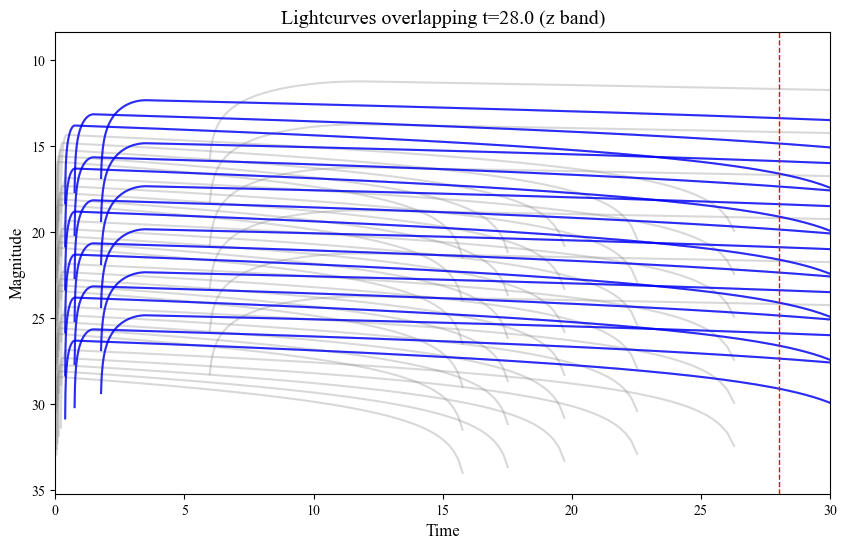

Number of lightcurves overlapping t=28.0: 18


In [225]:
target_time = 28.0
tolerance = 0.2

plt.figure(figsize=(10, 6))
count = 0

# Plot all lightcurves in gray first
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        plt.plot(time_z, mag_z, color='gray', alpha=0.3)

# Highlight lightcurves overlapping with the first vertical line
for model_id, model in model_dict.items():
    if isinstance(model, dict) and 'z' in model:
        time_z, mag_z = model['z']
        if any(abs(time_z - target_time) < tolerance):
            plt.plot(time_z, mag_z, color='blue', alpha=0.8)
            count += 1

# Draw the first vertical line
plt.axvline(x=target_time, color='red', linestyle='--', linewidth=1)

plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.xlim(0, 30)
plt.title(f'Lightcurves overlapping t={target_time} (z band)')
plt.gca().invert_yaxis()
plt.show()

print(f"Number of lightcurves overlapping t={target_time}: {count}")


In [ ]:
tolerance = 0.1

overlap_counts = []

for t in target_times:
    count = 0
    for model_id, model in model_dict.items():
        if isinstance(model, dict) and 'z' in model:
            time_z, mag_z = model['z']
            if any(abs(time_z - t) < tolerance):
                count += 1
    overlap_counts.append(count)

for t, count in zip(target_times, overlap_counts):
    print(f"Number of lightcurves overlapping t={t}: {count}")


Number of lightcurves overlapping t=2.0: 42
Number of lightcurves overlapping t=3.0: 48
Number of lightcurves overlapping t=22.0: 24


Target times (days since start): [ 2.  3. 22.]


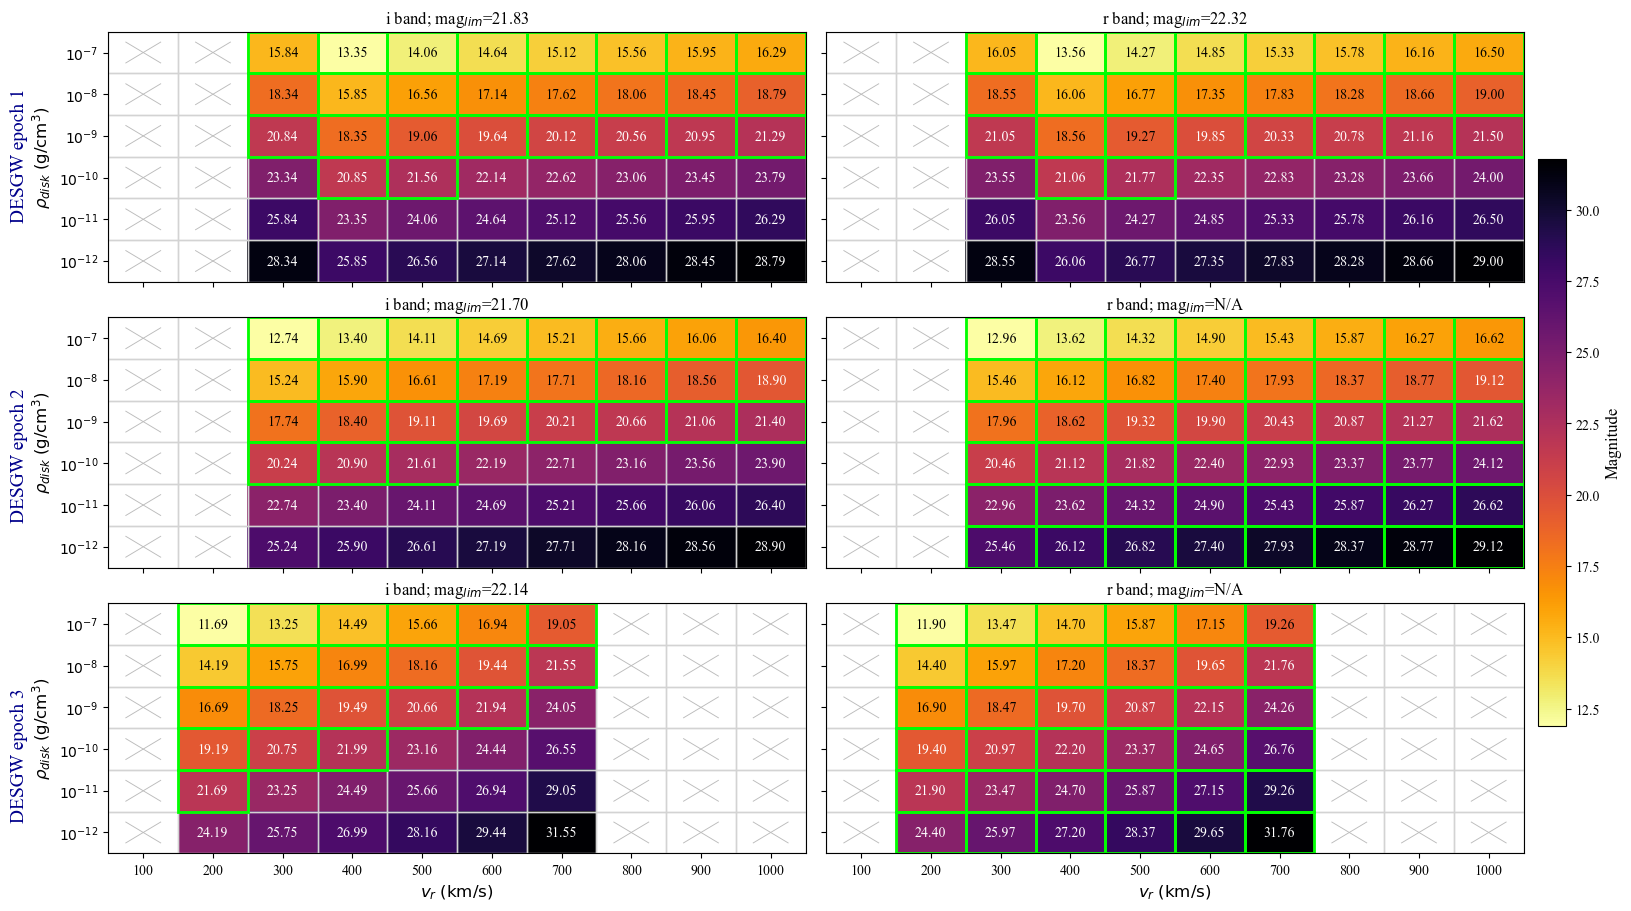

In [ ]:

print("Target times (days since start):", target_times)


tolerance = 0.2

vk_values = sorted(set(
    entry['params']['vk']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))
rho_values = sorted(set(
    entry['params']['rho']
    for entry in model_dict.values()
    if isinstance(entry, dict) and 'params' in entry
))

def format_rho(rho):
    exp = int(np.floor(np.log10(rho)))
    return f"$10^{{{exp}}}$"

plt.rcParams.update({
    
    "font.family": "serif",  # or "sans-serif" or "monospace"
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})


row_labels = ["DESGW epoch 1", "DESGW epoch 2", "DESGW epoch 3", "DESGW epoch 4", "DESGW epoch 5"]

desgw_bands =  set().union(*(d.keys() for d in obs_depths_decam))
desgw_titles = {'g': "g band", 'r': "r band", 'i': "i band", 'z': "z band"}

fig, axes = plt.subplots(len(target_times), len(desgw_bands), figsize=(16, 3*len(target_times)), constrained_layout=True, sharex='col', sharey='row')


for t_idx, t in enumerate(target_times):
    bands = desgw_bands
    band_titles = desgw_titles
    for b_idx, band in enumerate(bands):
        mag_matrix = np.full((len(rho_values), len(vk_values)), np.nan, dtype=float)
        for model_id, model in model_dict.items():
            if isinstance(model, dict) and band in model:
                time_b, mag_b = model[band]
                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    vk = model['params']['vk']
                    rho = model['params']['rho']
                    mag = mag_b[idx[0]]
                    i = rho_values.index(rho)
                    j = vk_values.index(vk)
                    if mag == np.inf:
                        mag_matrix[i, j] = np.nan
                    else:
                        mag_matrix[i, j] = mag

        ax = axes[t_idx, b_idx]
        im = ax.imshow(mag_matrix, origin='lower', aspect='auto', cmap='inferno_r')
        try:
            mag_lim = event_mags[t][band]#obs_depths_decam[band][t_idx]
        except (KeyError, TypeError):
            mag_lim = None

        if mag_lim is not None:
            limstr = f"mag$_{{lim}}$={mag_lim:.2f}"
        else:
            limstr = "mag$_{lim}$=N/A"
        ax.set_title(f"{band_titles[band]}; {limstr}", fontsize=12)

        if b_idx == 0:
            ax.set_ylabel(r'$\rho_{disk}\; (\text{g/cm}^3)$')
            #ax.tick_params(labelbottom=False)
        
        if t_idx == len(target_times) - 1:
            ax.set_xlabel(r'$v_r \; (\text{km/s})$')

        ax.set_xticks(np.arange(len(vk_values)))
        ax.set_xticklabels([f"{val:.0f}" for val in vk_values])
        ax.set_yticks(np.arange(len(rho_values)))
        ax.set_yticklabels([format_rho(val) for val in rho_values])

        norm = plt.Normalize(np.nanmin(mag_matrix), np.nanmax(mag_matrix))
        cmap = matplotlib.colormaps['inferno_r']
        
        for i in range(len(rho_values)):
            for j in range(len(vk_values)):
                rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=1, edgecolor='lightgray', facecolor='none', zorder=1)
                ax.add_patch(rect)
                if not np.isnan(mag_matrix[i, j]):
                    mag = mag_matrix[i, j]
                    rgba = cmap(norm(mag))
                    brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
                    text_color = 'white' if brightness < 0.50 else 'black'
                    ax.text(j, i, f"{mag:.2f}", ha='center', va='center', color=text_color, fontsize=10)
                    if mag < event_mags[t].get(band, np.inf): #obs_depths_decam[band][t_idx]:
                        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=2, edgecolor='lime', facecolor='none', zorder=2)
                        ax.add_patch(rect)
                else:
                    # Draw a very faint cross (X) in the empty cell for visual cue
                    ax.plot([j-0.25, j+0.25], [i-0.25, i+0.25], color='#bbbbbb', lw=0.65, zorder=3)
                    ax.plot([j-0.25, j+0.25], [i+0.25, i-0.25], color='#bbbbbb', lw=0.65, zorder=3)
    # Add row label (epoch) to the left of the row of subplots
    fig.text(0.001, 1 - (t_idx + 0.5) / len(target_times), row_labels[t_idx], va='center', ha='right', fontsize=14, color='darkblue', rotation=90)

fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, label='Magnitude')

plt.savefig(f'../figures/{superevent}_lightcurve_heatmaps_DECam_QSO_SED.jpeg', dpi=600, bbox_inches='tight')

plt.show()

/var/folders/7j/lt22v0hs7lb07jhzsq_g_w8w0000gn/T/ipykernel_23502/3159191908.py:100: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("viridis")


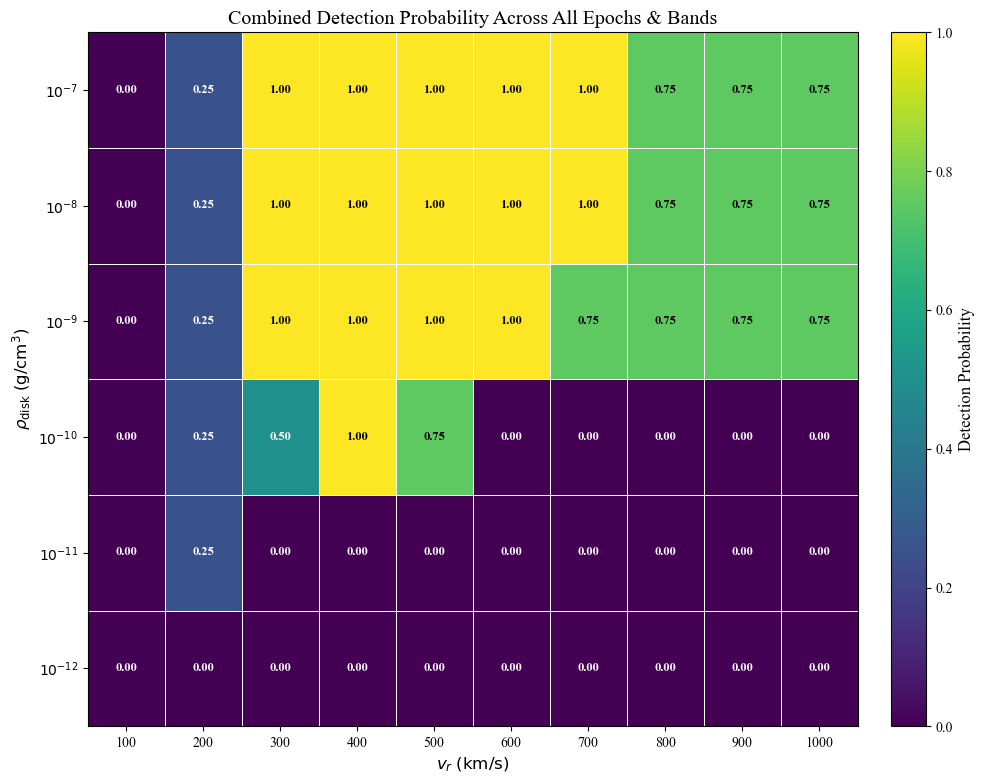

In [ ]:
all_bands = desgw_bands

n_rho = len(rho_values)
n_vk = len(vk_values)
prob_matrix = np.zeros((n_rho, n_vk), dtype=float)
count_matrix = np.zeros((n_rho, n_vk), dtype=int)   # number of comparisons (band×epoch with depth)
detect_matrix = np.zeros((n_rho, n_vk), dtype=int)  # number of detections

for model_id, model in model_dict.items():
    if not isinstance(model, dict) or 'params' not in model:
        continue

    vk = model['params']['vk']
    rho = model['params']['rho']

    i = rho_values.index(rho)
    j = vk_values.index(vk)

    detections = 0
    comparisons = 0

    for band in all_bands:
        for t_idx, t in enumerate(target_times):
            try:
                mag_lim = event_mags[t][band]
            except (KeyError, TypeError):
                mag_lim = None

            if mag_lim is None:
                continue

            comparisons += 1

            is_detection = False

            if band in model:
                time_b, mag_b = model[band]

                idx = np.where(np.abs(time_b - t) < tolerance)[0]
                if len(idx) > 0:
                    mag = mag_b[idx[0]]

                    if np.isfinite(mag):
                        if mag < mag_lim:
                            is_detection = True
                        else:
                            # mag is fainter or equal to limit => non-detection 
                            is_detection = False
                    else:
                        # mag is nan/inf => non-detection
                        is_detection = False
                else:
                    # no measurement at this epoch (cross) => non-detection
                    is_detection = False
            else:
                # model lacks this band => non-detection
                is_detection = False

            if is_detection:
                detections += 1

    count_matrix[i, j] = comparisons
    detect_matrix[i, j] = detections
    prob_matrix[i, j] = (detections / comparisons) if comparisons > 0 else 0.0

plt.figure(figsize=(10, 8))
ax = plt.gca()

im = ax.imshow(prob_matrix, origin='lower', cmap='viridis', vmin=0.0, vmax=1.0, aspect='auto')

ax.set_xticks(np.arange(n_vk))
ax.set_xticklabels([f"{v:.0f}" for v in vk_values])
ax.set_yticks(np.arange(n_rho))
ax.set_yticklabels([format_rho(r) for r in rho_values])

ax.set_xlabel(r"$v_r \; (\mathrm{km/s})$")
ax.set_ylabel(r"$\rho_{\rm disk} \; (\mathrm{g/cm}^3)$")
ax.set_title("Combined Detection Probability Across All Epochs & Bands")

norm = matplotlib.colors.Normalize(vmin=0.0, vmax=1.0)
cmap = matplotlib.cm.get_cmap("viridis")

for i in range(n_rho):
    for j in range(n_vk):
        prob = prob_matrix[i, j]
        comps = count_matrix[i, j]
        dets = detect_matrix[i, j]

        display_text = f"{prob:.2f}" if comps > 0 else "0.00"

        # decide text color by colormap brightness
        rgba = cmap(norm(prob))
        brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        text_color = "white" if brightness < 0.55 else "black"

        ax.text(j, i, display_text, ha='center', va='center', color=text_color, fontsize=9, fontweight='bold')

        # Draw thin rectangle around box
        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=0.7, edgecolor='white', facecolor='none')
        ax.add_patch(rect)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04, label="Detection Probability")
plt.tight_layout()
plt.savefig(f"../figures/{superevent}_combined_detection_probability_heatmap_QSO_SED.png", dpi=300)

plt.show()

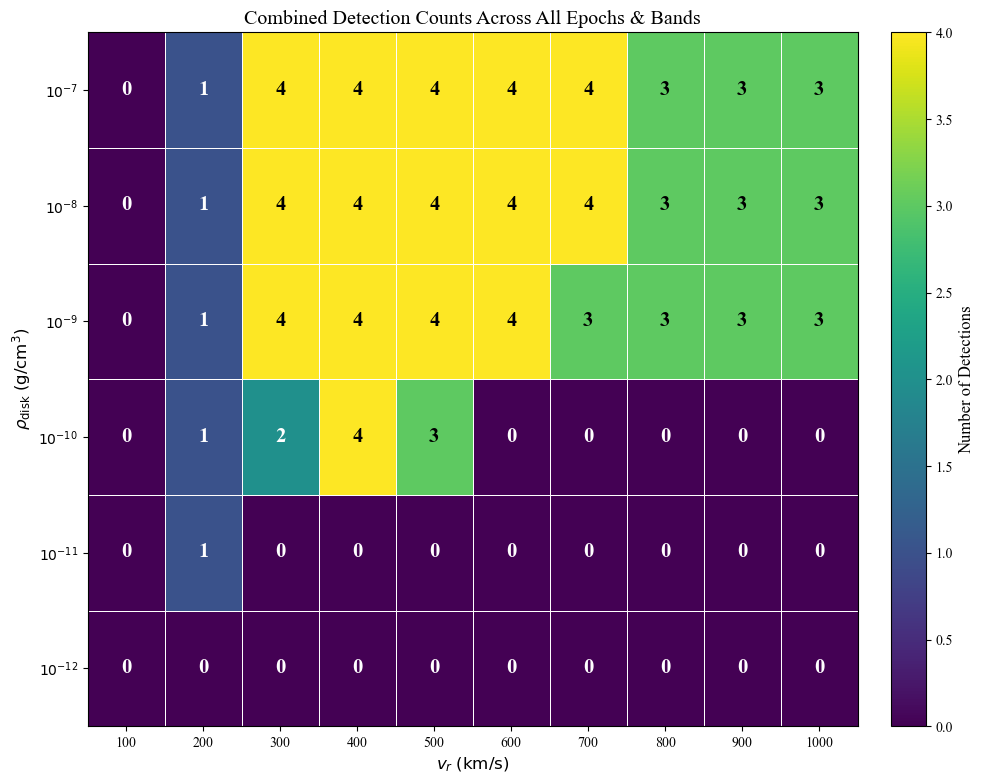

In [ ]:
# PLOT HEATMAP — NOW USING DETECTION COUNTS
plt.figure(figsize=(10, 8))
ax = plt.gca()

im = ax.imshow(detect_matrix, origin='lower', cmap='viridis', aspect='auto')

ax.set_xticks(np.arange(n_vk))
ax.set_xticklabels([f"{v:.0f}" for v in vk_values])
ax.set_yticks(np.arange(n_rho))
ax.set_yticklabels([format_rho(r) for r in rho_values])

ax.set_xlabel(r"$v_r \; (\mathrm{km/s})$")
ax.set_ylabel(r"$\rho_{\rm disk} \; (\mathrm{g/cm}^3)$")
ax.set_title("Combined Detection Counts Across All Epochs & Bands")

for i in range(n_rho):
    for j in range(n_vk):

        dets = detect_matrix[i, j]
        comps = count_matrix[i, j]

        display_text = f"{dets}"

        # brightness normalization for readability
        val = dets
        rgba = im.cmap((val - detect_matrix.min()) /
                       (detect_matrix.max() - detect_matrix.min() + 1e-6))
        brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
        text_color = "white" if brightness < 0.55 else "black"

        ax.text(j, i, display_text, ha='center', va='center',
                color=text_color, fontsize=15, fontweight='bold')

        rect = patches.Rectangle((j-0.5, i-0.5), 1, 1, linewidth=0.7, edgecolor='white', facecolor='none')
        ax.add_patch(rect)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04, label="Number of Detections")

'''ax.text(
    0.12, 0.11,                    # central location in figure coordinates (0..1)
    "PRELIMINARY",               # text
    fontsize=72,                 # large
    color="black",                # neutral color
    alpha=0.18,                  # low opacity so it stays in the background
    #ha="center", va="center",
    rotation=45,                 # diagonal
    transform=fig.transFigure,   # use figure coordinates so it spans whole figure
    zorder=0                     # put it behind regular plot elements
)'''

plt.tight_layout()
plt.savefig(f"../figures/{superevent}_combined_detection_counts_heatmap_QSO_SED.png", dpi=300)
plt.show()